<a href="https://colab.research.google.com/github/marinasr00/TADM/blob/main/Copia_de_MUMADE_TADM_S04_Razonamiento_Aproximado_(Oficial).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

## Carga de Datos

In [7]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 89.0MB/s]


1. Cargamos la extensión sql

In [8]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


2. Nos conectamos con la base de datos

In [9]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

Averiguamos los rangos de valores de los préstamos actuales del banco

In [10]:
%%sql loans << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
              WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans


3. Obtenemos el DataFrame

In [11]:
df = loans.DataFrame()
df.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


4. División de los datos en entrenamiento y test

In [12]:
X = df[["year", "amount", "duration", "payments","A11", "A13"]]
y = df["label"]

import numpy as np
X = np.asarray(X).astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Sistema Borroso
 

Vamos a crear un sistema de control borroso que modela cómo se puede evaluar la capacidad de un cliente para pedir un préstamo. Cuando se tiene que dar un préstamos se considerará la edad del peticionario, la cantidad del préstamos, la duración y los pagos en los que se divide. FInalmente nos dará una puntuación de 0 a 10 al préstamo. 


## Preliminares

https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html#example-plot-tipping-problem-newapi-py

* instalación de scikit-fuzzy

In [13]:
# https://pythonhosted.org/scikit-fuzzy/
!pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 33.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=fc40ac8231d64e6fea1d4b02dc21f0f80d0c80284d9e9e86fc2ad5133888ec33
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


* importación de librerías


In [14]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

##  Sistema Borroso



Los antecedentes van a ser edad, duración, pagos, y cantidad. 
Vamos a ver como se comportan estos valores en nuestra base de datos.

Definimos los Antecedentes mediante variables lingüísticas con un máximo y un mínimo y una serie de etiquetas para estas variables:

In [15]:
%%sql
SELECT min(duration), max(duration), min(payments), max(payments), min(amount), max(amount)
FROM LOAN


 * sqlite:///data_berka.db
Done.


min(duration),max(duration),min(payments),max(payments),min(amount),max(amount)
12,60,304,9910,4980,590820


In [16]:
%%sql 
SELECT min(edad), max(edad)
FROM (
SELECT 99 - substr(birth_number,0,3) edad
FROM CLIENT
)



 * sqlite:///data_berka.db
Done.


min(edad),max(edad)
12,88


Se van a establecer los rangos para cada variable:

1. Pagos

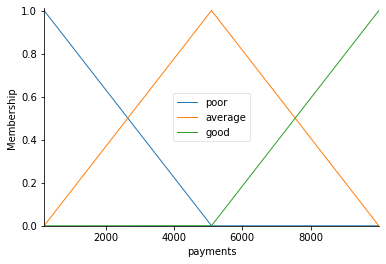

In [17]:
payments = ctrl.Antecedent(np.arange(200, 10000, 1), 'payments')
payments.automf(3)
payments.view()

trapmf --> es una función trapezoidal.

2. Edad

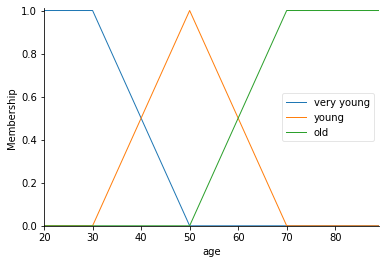

In [18]:
age = ctrl.Antecedent(np.arange(20,90, 1), 'age')
#age.automf(3, names = ["very young", "young", "old"])
age['very young'] = fuzz.trapmf(age.universe, [20, 20, 30, 50])
age['young'] = fuzz.trimf(age.universe, [30, 50, 70])
age['old'] = fuzz.trapmf(age.universe, [50, 70, 90, 90])
age.view()

3. Duración del préstamo:

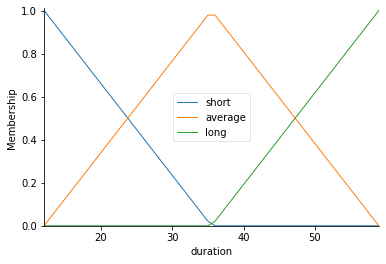

In [19]:
duration = ctrl.Antecedent(np.arange(12, 60, 1), 'duration')
duration.automf(3, names=["short", "average", "long"])
duration.view()

4. Cantidad:

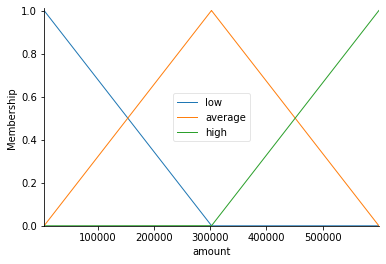

In [20]:
amount = ctrl.Antecedent(np.arange(5000, 600000, 1), 'amount')
amount.automf(3,  names = ["low","average","high"])
amount.view()

Finalmente, definimos el consecuente:

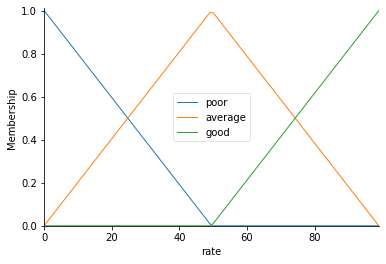

In [21]:
rate = ctrl.Consequent(np.arange(0, 100, 1), 'rate')
rate.automf(3)
rate.view()


## Reglas borrosas
-----------
Ahora, para hacer estos triángulos útiles, definimos la *relación borrosa*
entre las variables de entrada y salida. Para el ejemplo vamos a considerar las siguientes reglas simples (para hacer un sistema completo se necesitarían algunas más) 

1. Si la duración y la cantidad son pequeñas entonces la calificación será buena.
2. Si la cantidad es alta, los pagos pequeños y la duración alta entonces la calificación será *pobre*
3. Si la cantidad es media y los pagos también medios si la edad del cliente es baja entonces el rating es medio. 

La clave de estas reglas es que son borrosas, es decir, que expresamos la información de forma lingüística intentando manejar la incertidumbre inherente. 



Se establecen las reglas:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd50564dbd0>)

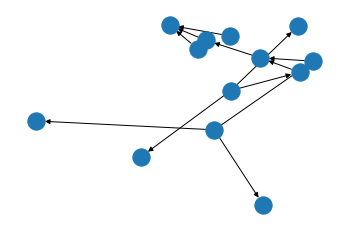

In [22]:
rule1 = ctrl.Rule(duration['short'] & amount['low'], rate['good'])
rule2 = ctrl.Rule(amount['high'] & payments['average'] & duration["long"], rate["poor"])
rule3 = ctrl.Rule(age['young'] & amount['average'], rate['average'])

rule1.view()

In [23]:
from google.colab import widgets

def show_rule(rule):
  grid = widgets.Grid(1, len(rule.antecedent_terms) + 1)
  i = 0
  for t in rule.antecedent_terms:
    with grid.output_to(0, i):
      t.view()
    i+=1  
  # show consequent  
  with grid.output_to(0, i):
    rule1.consequent[0].term.view()
    


Le digo que me muestre las 3 reglas que he establecido:

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

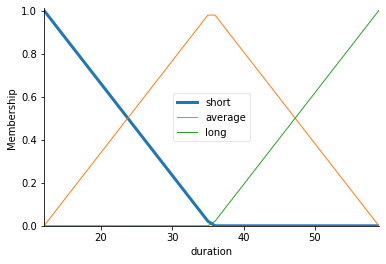

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

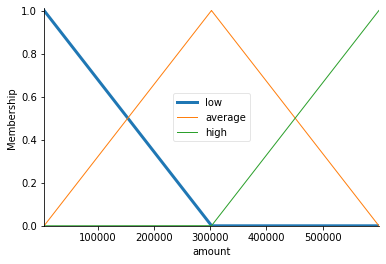

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

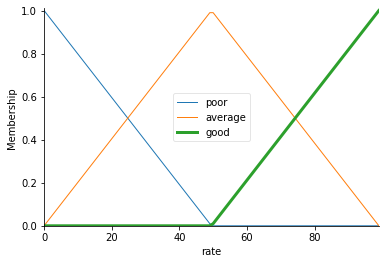

<IPython.core.display.Javascript object>

,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

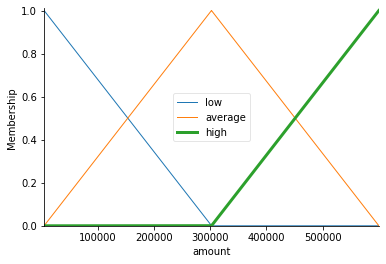

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

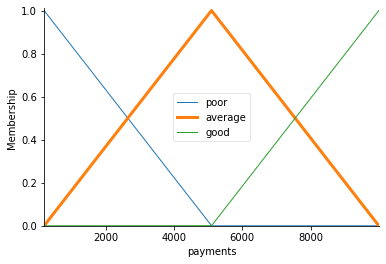

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

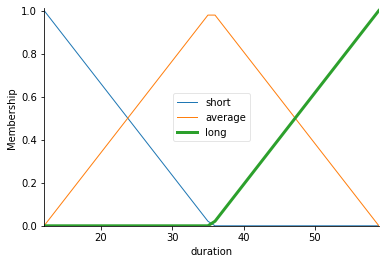

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

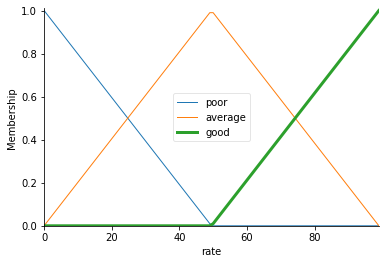

<IPython.core.display.Javascript object>

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

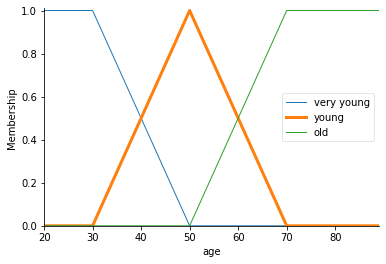

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

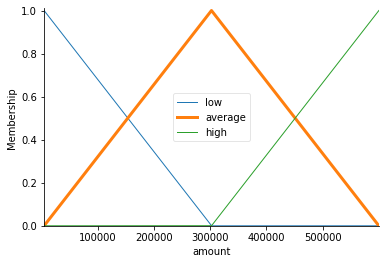

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

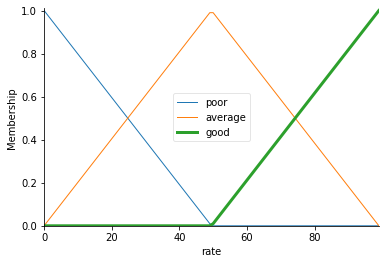

<IPython.core.display.Javascript object>

In [24]:
show_rule(rule1)
show_rule(rule2)
show_rule(rule3)

### Ejecución

Ahora que tenemos nuestras reglas definidas, podemos simplemente crear un sistema de control vía:

In [25]:
rating_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])


Con el fin de simular este sistema de control, crearemos un
"Sistema de Control y Simulación".  Este objeto que representa al controlador aplicado a un conjunto específico de circunstancias.  

In [26]:
rating = ctrl.ControlSystemSimulation(rating_ctrl)

Ahora podemos simular nuestro sistema de control simplemente especificando las entradas y llamando al método *compute*.  

*EJEMPLO*: Supongamos que un cliente de 40 años va a pedir un préstamos a 12 años con pagos de 2000€ y una cantidad de 300000€.

In [29]:
#@title Datos Básicos {run: "auto"}
rating.input['age'] = 40 #@param { type: "slider", min: 25 , max: 100, step: 1}
rating.input['duration'] = 12 #@param { type: "slider", min: 12 , max: 60, step: 1}
rating.input['payments'] = 2000  #@param { type: "slider", min: 0 , max: 10000, step: 1000}
rating.input['amount'] = 300000 #@param { type: "slider", min: 0 , max: 600000, step: 10000}

49.50556278236378


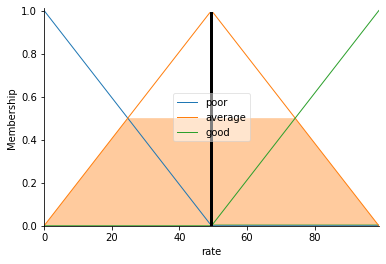

In [30]:
rating.compute()
print(rating.output['rate'])
rate.view(sim=rating)

En este caso, la cantidad es media, los pagos también medios y la edad del cliente es baja entonces el rating será medio (AVERAGE), aunque también hay posibilidad de que se posicione tanto en pobre como en bueno, por eso, se denomina "borroso".

49.50 será el centro de gravedad de nuestro sistema.

Siguiendo las mismas reglas establecidas:
*OTRO EJEMPLO: Supongamos que un cliente de 33 años va a pedir un préstamos a 15 años con pagos de 1000€ y una cantidad de 200000€.*

In [31]:
#@title Datos Básicos {run: "auto"}
rating.input['age'] = 33 #@param { type: "slider", min: 25 , max: 100, step: 1}
rating.input['duration'] = 15 #@param { type: "slider", min: 12 , max: 60, step: 1}
rating.input['payments'] = 1000  #@param { type: "slider", min: 0 , max: 10000, step: 1000}
rating.input['amount'] = 200000 #@param { type: "slider", min: 0 , max: 600000, step: 10000}

61.06794536221687


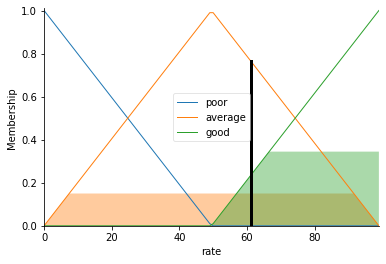

In [32]:
rating.compute()
print(rating.output['rate'])
rate.view(sim=rating)

En este caso, nuestro centro de gravedad sería 61.07. 
Esto quiere decir que la calificación del préstamo sería buena, dado que la duración y la cantidad es pequeña, aunque también hay posibilidad de que se posicione en un ratio medio.